In [1]:
import devito
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
Lx = 100.0   # width of the mantle in the x direction []
Ly = 100.0   # thickness of the mantle in the y direction []
nx = 401     # number of points in the x direction
ny = 401     # number of points in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction []
dy = Ly / (ny - 1)  # grid spacing in the y direction []
g = 9.81  # gravity acceleration [m/s^2]
alpha = 0.025 # friction coefficient for natural channels in good condition
# Maximum wave propagation time [s]
Tmax = 1.
dt = 1/4500.
nt = (int)(Tmax/dt)
print(dt, nt)

0.00022222222222222223 4500


In [3]:
from devito import Grid, TimeFunction, Function

grid = Grid(shape=(ny, nx), extent=(Ly, Lx))
eta = TimeFunction(name='eta', grid=grid, space_order=2)
M  = TimeFunction(name='M', grid=grid, space_order=2)
N  = TimeFunction(name='N', grid=grid, space_order=2)
h  = Function(name='h', grid=grid)
D  = Function(name='D', grid=grid)

print(N.data.shape)

Allocating memory for N(2, 405, 405)


(2, 401, 401)


In [4]:
import numpy
# Define the locations along a gridline.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Define initial eta, M, N
X, Y = numpy.meshgrid(x,y) # coordinates X,Y required to define eta, h, M, N

# Define constant ocean depth profile h = 50 m
h.data[:] = 50

# Define initial eta Gaussian distribution [m]
eta0 = 0.5 * numpy.exp(-((X-50)**2/10)-((Y-50)**2/10))

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0
D0 = eta0 + 50.

Allocating memory for h(403, 403)


In [5]:
eta.data[0] = eta0.copy()
M.data[0]   = M0.copy()
N.data[0]   = N0.copy()
D.data[:] = D0.copy()

print(eta0.shape, h.data.shape)

Allocating memory for eta(2, 405, 405)
Allocating memory for M(2, 405, 405)
Allocating memory for D(403, 403)


(401, 401) (401, 401)


In [6]:
from devito import sqrt
frictionTerm = g * alpha**2 * sqrt(M**2 + N**2 ) / D**(7./3.)
frictionTerm

0.00613125*sqrt(M(t, x, y)**2 + N(t, x, y)**2)*D(x, y)**(-2.33333333333333)

In [7]:
from devito import Eq, solve
pde_eta = Eq(eta.dt + M.dxc + N.dyc)
pde_M   = Eq(M.dt + (M**2/D).dxc + (M*N/D).dyc + g*D*eta.forward.dxc + frictionTerm*M)
pde_N   = Eq(N.dt + (M*N/D).dxc + (N**2/D).dyc + g*D*eta.forward.dyc + frictionTerm*N)

# Defining boundary conditions
x, y = grid.dimensions
t = grid.stepping_dim
bc_left   = Eq(eta[t+1, 0, y], eta[t+1, 1, y])
bc_right  = Eq(eta[t+1, nx-1, y], eta[t+1, nx-2, y])
bc_top    = Eq(eta[t+1, x, 0], eta[t+1, x, 1])
bc_bottom = Eq(eta[t+1, x, ny-1], eta[t+1, x, ny-2])

stencil_eta = solve(pde_eta, eta.forward)
stencil_M   = solve(pde_M, M.forward)
stencil_N   = solve(pde_N, N.forward)

update_eta  = Eq(eta.forward, stencil_eta, subdomain=grid.interior)
update_M    = Eq(M.forward, stencil_M, subdomain=grid.interior)
update_N    = Eq(N.forward, stencil_N, subdomain=grid.interior)
eq_D        = Eq(D, eta.forward + h)

update_eta

Eq(eta(t + dt, x, y), dt*(-Derivative(M(t, x, y), x) - Derivative(N(t, x, y), y) + eta(t, x, y)/dt))

In [8]:
update_M

Eq(M(t + dt, x, y), dt*(-0.00613125*sqrt(M(t, x, y)**2 + N(t, x, y)**2)*D(x, y)**(-2.33333333333333)*M(t, x, y) - 9.81*D(x, y)*Derivative(eta(t + dt, x, y), x) - Derivative(M(t, x, y)**2/D(x, y), x) - Derivative(M(t, x, y)*N(t, x, y)/D(x, y), y) + M(t, x, y)/dt))

In [9]:
update_N

Eq(N(t + dt, x, y), dt*(-0.00613125*sqrt(M(t, x, y)**2 + N(t, x, y)**2)*D(x, y)**(-2.33333333333333)*N(t, x, y) - 9.81*D(x, y)*Derivative(eta(t + dt, x, y), y) - Derivative(N(t, x, y)**2/D(x, y), y) - Derivative(M(t, x, y)*N(t, x, y)/D(x, y), x) + N(t, x, y)/dt))

In [10]:
from devito import Operator

optime = Operator([update_eta, bc_left, bc_right, bc_top, bc_bottom,
                   update_M, update_N, eq_D])

Operator `Kernel` generated in 1.31 s
  * lowering.Clusters: 0.73 s (56.0 %)
     * specializing.Clusters: 0.60 s (46.1 %)
        * factorize: 0.39 s (30.0 %)
  * lowering.IET: 0.30 s (23.1 %)
Flops reduction after symbolic optimization: [112 --> 75]


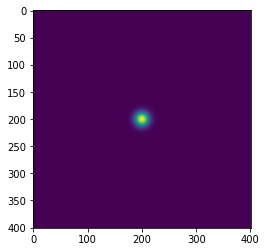

In [12]:
plt.imshow(eta.data[0])

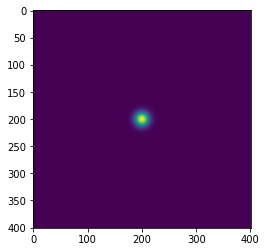

In [13]:
plt.imshow(M.data[0])

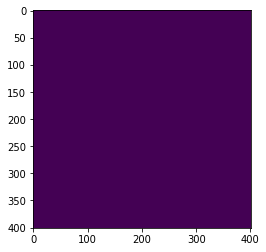

In [14]:
plt.imshow(N.data[0])

In [15]:
print(optime.ccode)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(struct dataobj *restrict D_vec, struct dataobj *restrict M_vec, struct dataobj *restrict N_vec, const float dt, struct dataobj *restrict eta_vec, struct dataobj *restrict h_vec, const float h_x, const float h_y, const int i0x_ltkn, const int i0x_rtkn, const int i0y_ltkn, const int i0y_rtkn, const int time_M, const int time_m, const int x_M, const int x_m, const in

Operator `Kernel` fetched `/run/user/1001/devito-jitcache-uid1001/ab6ad50fffe8ed6008e4de7bd97b70a6fa707a7a.c` in 0.02 s from jit-cache
Operator `Kernel` ran in 38.91 s
Global performance: [OI=0.01, 1.39 GFlops/s, 0.02 GPts/s]
Local performance:
  * section0<4501,399,399> ran in 5.74 s [OI=0.82, 1.63 GFlops/s, 0.13 GPts/s]
  * section2<<4501,401>,<4501,399,399>,<4501,401,401>> ran in 33.17 s [OI=0.01, 1.34 GFlops/s, 0.03 GPts/s]
Performance[mode=advanced] arguments: {}


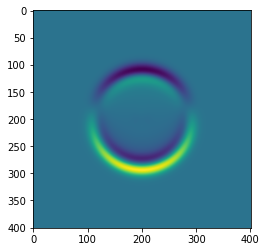

In [16]:
optime(time=nt, dt=dt)
plt.imshow(eta.data[1])

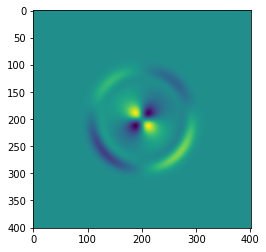

In [16]:
plt.imshow(N.data[1])

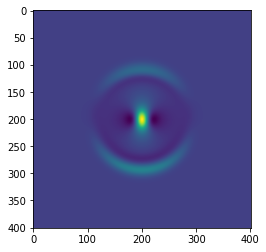

In [17]:
plt.imshow(M.data[1])

In [53]:
from devito import Grid, TimeFunction, Function, sqrt, Eq, solve, Operator
import numpy
def Shallow_water_2D(eta0, M0, N0, h0, g, alpha, nt, dx, dy, dt):
    """
    Computes and returns the discharge fluxes M, N and wave height eta from 
    the 2D Shallow water equation using the FTCS finite difference method.
    
    Parameters
    ----------
    eta0 : numpy.ndarray
        The initial wave height field as a 2D array of floats.
    M0 : numpy.ndarray
        The initial discharge flux field in x-direction as a 2D array of floats.    
    N0 : numpy.ndarray
        The initial discharge flux field in y-direction as a 2D array of floats.    
    h : numpy.ndarray
        Bathymetry model as a 2D array of floats.
    g : float
        gravity acceleration.
    alpha : float
        Manning's roughness coefficient.
    nt : integer
        Number fo timesteps.
    dx : float
        Spatial gridpoint distance in x-direction.
    dy : float
        Spatial gridpoint distance in y-direction.        
    dt : float
        Time step.
    """
    grid = Grid(shape=(ny, nx), extent=(Ly, Lx))
    eta = TimeFunction(name='eta', grid=grid, space_order=2)
    M   = TimeFunction(name='M', grid=grid, space_order=2)
    N   = TimeFunction(name='N', grid=grid, space_order=2)
    h   = Function(name='h', grid=grid)
    D   = Function(name='D', grid=grid)
    
    D0 = eta0.copy() + h0.copy()
    
    eta.data[0] = eta0.copy()
    M.data[0]   = M0.copy()
    N.data[0]   = N0.copy()
    D.data[:]   = D0.copy()
    
    frictionTerm = g * alpha**2 * sqrt(M**2 + N**2 ) / D**(7./3.)

    pde_eta = Eq(eta.dt + M.dxc + N.dyc)
    pde_M   = Eq(M.dt + (M**2/D).dxc + (M*N/D).dyc + g*D*eta.forward.dxc + frictionTerm*M)
    pde_N   = Eq(N.dt + (M*N/D).dxc + (N**2/D).dyc + g*D*eta.forward.dyc + frictionTerm*N)

    # Defining boundary conditions
    x, y       = grid.dimensions
    t          = grid.stepping_dim
    bc_left    = Eq(eta[t+1, 0, y], eta[t+1, 1, y])
    bc_right   = Eq(eta[t+1, nx-1, y], eta[t+1, nx-2, y])
    bc_top     = Eq(eta[t+1, x, 0], eta[t+1, x, 1])
    bc_bottom  = Eq(eta[t+1, x, ny-1], eta[t+1, x, ny-2])
    
    stencil_eta = solve(pde_eta, eta.forward)
    stencil_M   = solve(pde_M, M.forward)
    stencil_N   = solve(pde_N, N.forward)

    update_eta  = Eq(eta.forward, stencil_eta, subdomain=grid.interior)
    update_M    = Eq(M.forward, stencil_M, subdomain=grid.interior)
    update_N    = Eq(N.forward, stencil_N, subdomain=grid.interior)
    eq_D        = Eq(D, eta.forward + h)

    optime = Operator([update_eta, bc_left, bc_right, bc_top, bc_bottom,
                       update_M, update_N, eq_D])
    
    op(time=nt, dt=dt)
    print(eta.data[1])
    return eta.data[1]

## Example I: Tsunami in an ocean with constant depth

After writing the `Shallow_water_2D` code and all the required functions attached to it, we can define and run our first 2D Tsunami modelling run.

Let's assume that the ocean model is $ L_x = 100\; m$ in x-direction and $L_y = 100\; m$ in y-direction. The model is discretized with $nx=401$ gridpoints in x-direction and $ny=401$ gridpoints in y-direction, respectively.

In this first modelling run, we assume a constant bathymetry $h=50\;m$. The initial wave height field $\eta_0$ is defined as a Gaussian at the center of the model, with a half-width of 10 m and an amplitude of 0.5 m. Regarding the initial discharge fluxes, we assume that 

\begin{equation}
\begin{split}
M_0(x,y) &= 100 \eta_0(x,y)\\
N_0(x,y) &= 0\\
\end{split}\notag
\end{equation}

Furthermore, Dirichlet boundary conditions for the discharge fluxes $M,\;N$ are assumed at all boundaries: 

\begin{equation}
\begin{split}
M(0,y) &= M(L_x,y) = M(x,0) = M(x,L_y) = 0\\  
N(0,y) &= N(L_x,y) = N(x,0) = N(x,L_y) = 0\\  
\end{split} \notag
\end{equation}

For the wave height field $\eta$, it is essential that Neumann boundary conditions are set at all boundaries:

\begin{equation}
\begin{split}
&\frac{\partial \eta}{\partial x}(0,y) = 0\\
&\frac{\partial \eta}{\partial x}(L_x,y) = 0\\
&\frac{\partial \eta}{\partial y}(x,0) = 0\\
&\frac{\partial \eta}{\partial y}(x,L_y) = 0\\
\end{split}\notag
\end{equation}

in order to avoid the occurence of high frequency artifacts, when waves are interacting with the boundaries. Notice, that the assumed boundary conditions lead to significant boundary reflections which might be not realistic for a given problem. However, to keep the problem simple, we will not try to mitigate the boundary reflections. 

In [54]:
Lx = 100.0   # width of the mantle in the x direction []
Ly = 100.0   # thickness of the mantle in the y direction []
nx = 401     # number of points in the x direction
ny = 401     # number of points in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction []
dy = Ly / (ny - 1)  # grid spacing in the y direction []
g = 9.81  # gravity acceleration [m/s^2]
alpha = 0.025 # friction coefficient for natural channels in good condition
# Maximum wave propagation time [s]
Tmax = 1.
dt = 1/4500.
nt = (int)(Tmax/dt)
print(dt, nt)

0.00022222222222222223 4500


In [55]:
# Define the locations along a gridline.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Define initial eta, M, N
X, Y = numpy.meshgrid(x,y) # coordinates X,Y required to define eta, h, M, N

# Define constant ocean depth profile h = 50 m
h0 = 50. * numpy.ones_like(X)

# Define initial eta Gaussian distribution [m]
eta0 = 0.5 * numpy.exp(-((X-50)**2/10)-((Y-50)**2/10))

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0
D0 = eta0 + 50.

Operator `Kernel` ran in 23.08 s


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


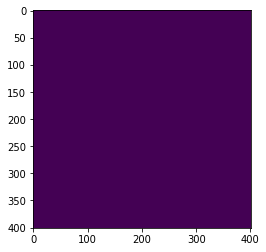

In [56]:
eta = Shallow_water_2D(eta0, M0, N0, h0, g, alpha, nt, dx, dy, dt)

#print(eta.data[0])
plt.imshow(eta)

In [26]:
print(op.ccode)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(struct dataobj *restrict D_vec, struct dataobj *restrict M_vec, struct dataobj *restrict N_vec, const float dt, struct dataobj *restrict eta_vec, struct dataobj *restrict h_vec, const float h_x, const float h_y, const int i0x_ltkn, const int i0x_rtkn, const int i0y_ltkn, const int i0y_rtkn, const int time_M, const int time_m, const int x_M, const int x_m, const in